# Exam GRA 6670 - 2023

ID 1: 1077860

ID 2: 1032897

# 1. Introduction

The purpose of this project is to develop and test a signal based trading strategy with machine learning techniques. First, we will simulate stock prices using Geometric Brownian Motion (Source), which will be used as data in two different machine learning models. The first model will be a Logistic Regression, and the second model will be a Neural Network. In our context, both models will be supervised. The Logistic Regression will aim to predict buy and sell signals directly based on previously identified optimal buying and selling points (labels). While the Neural Network will produce forecasts of the different asset prices, before defining the signals based on the forecasts. In the end, we will simulate trading with the predicted signals for both models to see if the strategy is profitable or not. In order to fully understand the performance of the strategy, we will also perform a Monte Carlo simulation of the trading strategy for both models.

As mentioned, before the Logistic Regression is constructed and applied the optimal signals (labels) has to be identified. The simplest way to do this is to take the first difference (FD) of the price and identify the signals based on changes in the sign of the FD. Another way is to interpolate a function for the whole price series and find where the derivative is equal to 0. As we will see, the interpolation offers more flexibility and insight into trends. We will use both methods and compare them.

We will also construct a Moving Average Convergence/Divergence (MACD) indicator. The MACD indicator produce signals in 'real time' based on different moving averages. We will therefore use it as a feature in the Logistic Regression, to help predict the optimal signals.

For comparison, we implemented a Neural Network approach, in which we train a three-layer model with stock data from different assets and try to predict the prices 10 periods ahead. Based on the predictions, there was a simple trading strategy implemented, that gives trading signals based on the slope of the prediction curve and the standard deviation of the predicted time series. This approach has a proof-of-concept character and is not aimed at achieving high-quality economic results. This requires complex fine-tuning of the model, which cannot be realised within this framework.

## 1.1 Description of Numerical Methods

1. Simulation
   - Simulation of a stochastic process, applied with GBM
   - Simulation of trading, applied with prices and predicted signals for each model
1. Interpolation
   - Cubic Spline interpolation through a number of points, applied in signal and trend identification
1. Optimization
   - Gradient Descent, applied in both machine learning models to optimize weights and biases to minimize the loss function
1. Monte Carlo simulation
   - Simulating the trading strategy for different baskets of assets

# 2. Theory and Model Descriptions

## 2.1 Geometric Brownian Motion

A Geometric Brownian Motion ([GBM](https://en.wikipedia.org/wiki/Geometric_Brownian_motion)) is a continuous-time stochastic process in which the logarithm of the randomly varying quantity follows a Brownian motion (Wiener process) with drift.

GBM is one of the most popular methods for simulating stock prices, but it can be used to simulate any financial asset $S_t$. Most notably, GBM is used in the Black-Scholes model to simulate the underlying stock price.

We will use GBM to simulate stock price data for a basket of different stocks. The synthetic data will later be used to train and test the different machine learning models

### 2.1.1 Derivation of GBM for $S_t$

The asset $S_t$ is following a GBM if its dynamics follow the Stochastic Differential Equation (SDE):

$$ dS_t = μS_tdt + σS_tdW_t $$

Where $μ$ is the drift (risk free rate in perfect markets), $σ$ is the volatility (standard deviation) of the asset, $dt$ is an infinitely small time step, and $W_t$ is a Wiener process (Brownian motion) such that it has independent increments $dW_t$ which have mean 0 and variance $dt$, $dW_t ∼ N(0,dt)$.

Using [Itô's lemma](https://en.wikipedia.org/wiki/It%C3%B4%27s_lemma#Geometric_Brownian_motion) with $f(S_t) = ln(S_t)$ gives:

$$ dln(S_t) = \left( μ - \frac{σ^2}{2} \right)dt + σdW_t $$

By taking the integral of $dln(S_t)$ from 0 to 1 and assuming that $W_0 = 0$, it can be shown that the solution to the SBE is:

$$ S_t = S_0 \exp \left( \left( \mu - \frac{σ^2}{2} \right) t + σW_t \right) $$

Where $S_0$ is the initial value of the asset. Thus, the asset $S_t$ evolves exponentially with Brownian motion, imitating the behavior of financial assets.

The above solution of the SBE is a continious function. For our purposes, we need to implement the function discretely. It then follows that $Var(dW_t) = dt$ → $Var(ΔW_t) = Δt$. Since the increments $Δt > 0$, $σ_{W_t} = \sqrt{Var(ΔW_t)} = \sqrt{Δt}$. Using that $ΔS_t = S_{t + Δt} - S_t$ and $ΔW_t = W_{t + Δt} - W_t$ in the integral from $t$ to $t + Δt$, we get the following discrete solution:

$$ S_{t+Δt} = S_t \exp \left( \left( \mu - \frac{σ^2}{2} \right) Δt + σΔW_t \right) $$

Since $ΔW_t$ is a Wiener process, $ΔW_t ∼ N(0,Δt)$, it can be written as $\sqrt{Δt} Z_t$, where $Z_t ∼ N(0,1)$:

$$ S_{t+Δt} = S_t \exp \left( \left( \mu - \frac{σ^2}{2} \right) Δt + σ\sqrt{Δt} Z_t \right) $$

For any $Δt \geq 0$. Which is the equation we will implement to generate synthetic stock price data.

## 2.2 Cubic Spline Interpolation

A cubic spline is a piecewise cubic polynomial $S(x)$ that passes through a set of $n$ data points. In each interval $[x_k, x_{k+1}]$, the spline $S(x)$ is defined by a cubic polynomial:

$$ S_k(x) = a_k + b_k (x - x_k) + c_k (x - x_k)^2 + d_k (x - x_k)^3 $$

Where $a_k$, $b_k$, $c_k$, $d_k$ are the spline coefficients for the $k^{th}$ interval. Creating such an interpolation has the advantage that we can take the derivative at any point over a continious function, which can help us in identifying trends and when there is a peak or a trough in the price. The number of interpolation points we choose will determine how smooth the spline will be, the fewer points the smoother.

The cubic spline will be used to obtain a function going through $n$ points in our data, providing functions for $n-1$ intervals.

$S_k(x)$ has the analytical derivative:

$$ S_k'(x) = b_k + 2c_k (x - x_k) + 3d_k (x - x_k)^2 $$

## 2.3 MACD Indicator

The MACD indicator is a popular technical indicator used in trading and investment analysis. It is used to identify potential trends and reversals in the price of an asset. The indicator consists of two main components, the MACD line and the signal line. The MACD line is derived by subtracting the 26-period Exponential Moving Average (EMA) from the 12-period EMA. The signal line is a 9-period EMA of the MACD line. When the MACD line crosses above the signal line, it is seen as a bullish signal. Conversely, when it crosses below the signal line, it is considered bearish.

To obtain the MACD components, we first have to define the EMA, which can be obtained in various different ways. Here we will use the following specification:

$$ EMA_{0,k} = Price_{0,k} $$

$$ EMA_{t,k} = \alpha Price_t + (1-\alpha) EMA_{t-1,k} \text{ , } \alpha = \frac{2}{k + 1} $$

Where $EMA_{t,k}$ and $EMA_{t-1,k}$ is the Exponential Moving Average at time $t$ and $t-1$ respectively, $Price_t$ is the asset price at time $t$, $\alpha$ is a smoothing factor and $k$ is the number of days set for the moving average.

Once the EMA is defined, the MACD line and the signal line can be computed as the following:

$$ MACD_t = EMA_{t,12} - EMA_{t,26} $$

$$ MACD Signal_t = EMA_{t,9} (MACD_t) $$

Where $EMA_{t,12}$ and $EMA_{t,26}$ is the 12- and 26-day EMA of the asset price, and $EMA_{t,9} (MACD_t)$ is the 9-day EMA of the MACD.

## 2.4 Logistic Regression

The Logistic Regression model is the first of our two machine learning models. This model is multinomal and could be used for any number of classifications. Since our purpose with this model is to predict buy and sell signals directly, we will use three classes; buy (1), sell (-1) and hold/do nothing (0). This model has three main equations:

In this setup there will be $n$ number of features (independent variables) and $m$ number of training samples in the model.

$$ Z = W^TX + b \tag1 $$
$$ \hat{Y} = \sigma{(Z)} = \frac{\exp (Z)}{\sum \exp (Z)} \tag2 $$
$$ L(\hat{Y}, Y) = - \frac{1}{m} [Ylog(\hat{Y})] \tag3 $$

In equation $(1)$, $W^T$ is a $3 \times n$ matrix containing the weights, $X$ is a $n \times m$ matrix containing the features, such that $Z$ is a $3 \times m$ matrix of predicted raw scores. $b$ is a $3 \times 1$ vector containing the biases for each class. This equation performs the predictions for each sample where each of the three rows in $Z$ represents one class.

In equation $(2)$, directly applying the softmax function, $\sigma(Z)$, to $Z$ still leaves $\hat{Y}$ a $3 \times m$ matrix. The softmax function takes the element-wise exponential of $Z$ and divides it on the sum of the element-wise exponentials for each column in $Z$. This normalizes the elements in $Z$ such that they are all represented as probabilities between 0 and 1 that sum to 1 for each sample. The output matrix with all the predicted probabilities is then represented by $\hat{Y}$.

In equation $(3)$, $Y$ contains the true/optimal signals. All the operations are element-wise, and the true value matrix $Y$ is a $3 \times m$ matrix, such that $L$ will be a $3 \times m$ matrix. This equation is the cross-entropy loss function which we will minimize when training the model, using gradient descent.

Given the actual values $Y$, we want to minimize the loss $L$ by using gradient descent. In a nutshell, gradient descent is a method to find the minimum of a function by iteratively moving in the steepest descent direction, determined by the negative of the gradient of the function. We will basically take the derivative w.r.t. our weights $W$ and biases $b$ and adjust to move the loss the optimum.

The updating formulas for $W$ and $b$ is:

$$W = W - \gamma \frac{dL}{dW}$$

$$b = b - \gamma \frac{dL}{db}$$

Where $\gamma$ is the learning rate. In order to get the derivatives we have to apply the chain rule:

$$\frac{dL}{dW} = \frac{dL}{d\hat{Y}} \cdot \frac{d\hat{Y}}{dZ} \cdot \frac{dZ}{dW} = \frac{1}{m} X (\hat{Y} - Y)^T $$

$$\frac{dL}{db} = \frac{dL}{d\hat{Y}} \cdot \frac{d\hat{Y}}{dZ} \cdot \frac{dZ}{db} = \frac{1}{m} \sum_{i=1}^{m} (\hat{Y}_i - Y_i) $$

## 2.5 Neural Network

The Neural Network is our second machine learning model. The model uses a $swish$ activation function, and the network has 3 layers with weights and biases for each layer.

With $x$ as the input the $swish$ function is simply represented by $x$ multiplied with the $sigmoid$ function, giving the following representation:

$$ swish(x) = \frac{x}{1 + e^{-x}} $$

Its deriviative is then:

$$ swish(x) + \frac{1}{1 + e^{-x}} (1 - swish(x)) $$

The model uses lasso regularization to prevent overfitting, and uses stochastic gradient descent to minimize the loss function

# 3. Analysis

## 3.1 Stock Price Simulation

First a function for generating a correlation matrix that is symmetric and positive definite is defined. Then the Cholesky decomposition is used to generate correlated random samples efficiently. The primary advantage of using Cholesky decomposition in this context is that it allows us to transform uncorrelated random samples into correlated ones.

The Cholesky decomposition decomposes the correlation matrix into the product of a lower triangular matrix ($Q$) and its transpose ($Q^T$). Mathematically, if $R$ is the correlation matrix, Cholesky decomposition provides $R=Q⋅Q^T$.

The line epsilon_array = np.inner(random_array, Q) is where the Cholesky decomposition comes into play. random_array is a vector of independent standard normal random samples (uncorrelated). The inner product with $Q$ transforms these uncorrelated samples into correlated samples. The resulting epsilon_array now has the desired correlation structure specified by the original correlation matrix.

### Algorithm

Inputs:
  - $\mu$: Drift coefficient/risk-free rate
  - $T$: Number of days (time steps)
  - $\Delta t$: One time step
  - $m$: Number of assets
  - $\sigma$: standard deviations

Outputs:
  - $S_{i,t}$: Simulated stock prices
  - $days$: x grid with $T$ time steps

Steps:

1. Initialize asset names, random volatilites, matrix $S$ and the correlation matrix

1. Compute the Cholesky decomposition of the correlation matrix $(Q)$

1. Simulate the stock prices:
   - For each day t in range(1,T) the errors for each asset based on a standard normal distribution and Q is computed
     - for each day t and asset n in range(m) the stock price $S_{i,t}$ is computed with the GBM formula
     $$ S_{t+Δt} = S_t \exp \left( \left( \mu - \frac{σ^2}{2} \right) Δt + σ\sqrt{Δt} Z_t \right) $$

1. Outputs a matrix S, containing stock prices for m assets and T days

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
class StockPriceSimulator:
    # Simulation of a basket of m correlated assets
    def __init__(self, mu, T, m):
        self.mu = mu                                                    # drift coefficient/risk-free rate
        self.T = T                                                      # number of steps
        self.m = m                                                      # number of assets
        self.delta_t = 1 / T                                            # time step calculation
        self.asset_names = [f'Asset {i}' for i in range(1, m + 1)]      # generate asset names
        self.vols_data = np.random.uniform(low=0.2, high=0.8, size=m)   # generate random volatilities
        self.corr_matrix = self.generate_correlation_matrix()           # generate correlation matrix

    # Generate a random correlation matrix for m assets
    def generate_correlation_matrix(self):
        while True:
            corr_matrix = np.random.uniform(low=0.0, high=1.0, size=(self.m, self.m))
            corr_matrix = (corr_matrix + corr_matrix.T) / 2
            np.fill_diagonal(corr_matrix, 1.0)
            try:
                np.linalg.cholesky(corr_matrix)
                return corr_matrix
            except:
                corr_matrix = np.full((self.m, self.m), 0.0)

    # Simulating stock time series
    def simulate_stock_prices(self):
        S = np.full((self.m, self.T), 100.0)                            # initial matrix
        Q = np.linalg.cholesky(self.corr_matrix)                        # cholesky decomposition

        for t in range(1, self.T):
            random_array = np.random.normal(size=self.m)
            epsilon_array = np.inner(random_array, Q)

            for n in range(self.m):
                sigma = self.vols_data[n]
                epsilon = epsilon_array[n]
                S[n, t] = S[n, t-1] * np.exp((self.mu - sigma ** 2 / 2) * self.delta_t + sigma * np.sqrt(self.delta_t) * epsilon)

        return S

    # Creating dataframe with assetname A, B, C,...
    def get_stock_prices_df(self, S):
        alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
        column_names = list(alphabet)[:self.m]
        stock_prices = pd.DataFrame({col: S[i] for i, col in enumerate(column_names)})
        return stock_prices

    def run_simulation(self):
        S = self.simulate_stock_prices()
        return self.get_stock_prices_df(S)

## 3.2 Cubic Spline Interpolation

In this section three functions are defined. The first 'cubic_spline' takes x and y values for a set of interpolation points and returns vectors containing the coefficients for each interval. The second 'spline_eval' takes the x values for the interpolation points, the coefficient vectors and one x value for evaluation. Then it evaluates the spline at the selected point. The last function 'spline_derivative' takes the same arguments as the 'spline_eval' function, except for the a coefficient vector. It returns the evaluated derivative at the selected point.

The calculation of the coefficients in 'cubic_spline' is quite involved. It involves setting up and solving a tridiagonal linear system of equations to solve for $c$. For a reference see [here](https://en.wikipedia.org/wiki/Spline_interpolation). However, our computation differs in that we compute the coefficients directly and are not concerned with first and second derivatives and slopes.

### Algorithm

Inputs:
  - $num$: Number of interpolation points
  - $A$: Selected asset price
  - $days$: x grid with $T$ time steps

Output:
  - $a$, $b$, $c$, $d$: Spline coefficient vectors
  - $y\_grid$: y grid containing evaluated spline values for all days

Steps:

1. Extract selected stock price from dataframe

1. Create x grid for the number of interpolation points $num$ and flooring it to avoid decimal numbers, then get the corresponding y values from the stock price series

1. Run the 'cubic_spline' function to get the coefficient vectors and evaluate the spline across $days$ to get the spline evaluated at every period

1. Outputs the coefficient vectors $a$, $b$, $c$, $d$ and the evaluated $y\_grid$

### 3.2.1 Different Number of Interpolation Points

Setting $num = 1000$ gives 999 intervals and the spline fits more or less exactly to the underlying stock price, as it should.

Setting $num = 101$ gives 100 intervals and the spline is smoothed a lot more, and the spline is starting to show trends over time

Setting $num = 51$ gives 50 intervals and the spline is now much smoother with most of the noise gone and displaying cycle like behavior

Later when we will define the optimal buy/sell points, $num$ will have an effect on how many signals that will be identified. The argument for using less than $num = 1000$ is that, as we will see, using 1000 points will almost make the identification equal to that when using the first difference of the stock price. Another is that identifying every peak and trough generated by what is mostly statistical noise makes little sense in practice. It might be more useful to try to identify peaks and troughs mainly through trend identification.

In [5]:
class CubicSplineInterpolator:
    # Interpolates cubic splines through a set number of points
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.a, self.b, self.c, self.d = self.cubic_spline()

    # Creating cubic spline interpolation
    def cubic_spline(self):
        n = len(self.x)
        a = np.array(self.y)
        h = np.diff(self.x)

        # Solving the system of equations
        A = np.zeros((n, n))
        b = np.zeros(n)

        for i in range(1, n - 1):
            A[i, i - 1] = h[i - 1]
            A[i, i] = 2 * (h[i - 1] + h[i])
            A[i, i + 1] = h[i]
            b[i] = 3 * ((a[i + 1] - a[i]) / h[i] - (a[i] - a[i - 1]) / h[i - 1])

        A[0, 0] = A[n - 1, n - 1] = 1
        b[0] = b[n - 1] = 0

        c = np.linalg.solve(A, b) # for computation speed

        # Calculating the b and d coefficients
        b = np.zeros(n - 1)
        d = np.zeros(n - 1)
        for k in range(n - 1):
            b[k] = (a[k + 1] - a[k]) / h[k] - h[k] * (2 * c[k] + c[k + 1]) / 3
            d[k] = (c[k + 1] - c[k]) / (3 * h[k])

        return a, b, c, d

    # Creating function to evaluate the spline at specific points
    def spline_eval(self, x_new):
        n = len(self.x)
        if x_new < self.x[0] or x_new > self.x[-1]:
            raise ValueError("x_new is out of the interpolation range.")

        for k in range(n - 1):
            if self.x[k] <= x_new <= self.x[k + 1]:
                delta = x_new - self.x[k]
                return self.a[k] + self.b[k] * delta + self.c[k] * delta**2 + self.d[k] * delta**3

    def spline_derivative(self, x_new):
        n = len(self.x)
        if x_new < self.x[0] or x_new > self.x[-1]:
            raise ValueError("x_new is out of the interpolation range.")

        for k in range(n - 1):
            if self.x[k] <= x_new <= self.x[k + 1]:
                delta = x_new - self.x[k]
                return self.b[k] + 2 * self.c[k] * delta + 3 * self.d[k] * delta**2

## 3.3 Signal Generation

### 3.3.1 First Difference
Using the first difference we can identify the price change from yesterday to today for all $t$. The following code computes the first difference of the stock price and then identifies the true signals based on whether the sign of the first difference has changed, and in what direction, from today to tomorrow. A buy/sell signal then indicates that you should buy/sell tomorrow.

### 3.3.2 Interpolated Signals
The same can be done using the interpolation. The code below computes the derivative from the spline across the entire 1000 days. The following code computes the derivative of the spline and then identifies the true signals based on whether the sign of the derivative has changed, and in what direction, from today to tomorrow. A buy/sell signal then indicates that you should buy/sell tomorrow.

Using the method for directly identifying when the derivative is equal to 0 did not identify all peaks/troughs on the spline, we therefore used the method described above instead.

In [6]:
class SignalProcessor:
    # Computes the signals used for labels
    def __init__(self, dataframe, asset_name, x, a, b, c, d):
        self.dataframe = dataframe
        self.asset_name = asset_name
        self.x = x
        self.a = a
        self.b = b
        self.c = c
        self.d = d

    # Computing the first difference (FD) of the asset price
    def first_difference(self):
        col_name = f'{self.asset_name}_FD'
        self.dataframe[col_name] = self.dataframe[self.asset_name].diff(1)
        return self.dataframe

    # Identifying signals by looking for changes in the sign of the FD
    def get_FD_signals(self):
        self.dataframe = self.first_difference()
        col_name = f'{self.asset_name}_FD'
        signals = np.sign(self.dataframe[col_name]).shift(-1)
        self.dataframe[f'{self.asset_name}_FD_signs'] = signals
        signals_list = [signals[0]]
        for i in range(1, len(self.dataframe)):
            if signals[i] == signals[i - 1]:
                signals_list.append(0)
            else:
                signals_list.append(signals[i])
        self.dataframe[f'{self.asset_name}_FD_Buy'] = np.nan
        self.dataframe[f'{self.asset_name}_FD_Sell'] = np.nan
        for i in range(len(self.dataframe)):
            if signals_list[i] == 1:
                self.dataframe.loc[i, f'{self.asset_name}_FD_Buy'] = self.dataframe.loc[i, self.asset_name]
            elif signals_list[i] == -1:
                self.dataframe.loc[i, f'{self.asset_name}_FD_Sell'] = self.dataframe.loc[i, self.asset_name]
        return self.dataframe

    def spline_derivative(self, x_new):
        n = len(self.x)
        if x_new < self.x[0] or x_new > self.x[-1]:
            raise ValueError("x_new is out of the interpolation range.")

        for k in range(n - 1):
            if self.x[k] <= x_new <= self.x[k + 1]:
                delta = x_new - self.x[k]
                return self.b[k] + 2 * self.c[k] * delta + 3 * self.d[k] * delta**2

    # Computing the derivative across the entire grid (time periods)
    def derivative(self):
        x_grid = np.linspace(self.x[0], self.x[-1], len(self.x), dtype=int)
        derivative_values = [self.spline_derivative(xi) for xi in range(len(x_grid))]
        self.dataframe[f'{self.asset_name}_Derivative'] = derivative_values
        return self.dataframe

    # Getting the interpolated signals
    def get_interp_signals(self):
        self.dataframe = self.derivative()
        col_name = f'{self.asset_name}_Derivative'
        signals = np.sign(self.dataframe[col_name]).shift(-1).fillna(0).astype(int)
        self.dataframe[f'{self.asset_name}_Derivative_signs'] = signals
        buy_sell = [signals[0]]
        for i in range(1, len(self.dataframe)):
            if signals[i] == signals[i - 1]:
                buy_sell.append(0)
            else:
                buy_sell.append(signals[i])
        self.dataframe[f'{self.asset_name}_Interp_Buy'] = np.nan
        self.dataframe[f'{self.asset_name}_Interp_Sell'] = np.nan
        for i in range(len(self.dataframe)):
            if buy_sell[i] == 1:
                self.dataframe.loc[i, f'{self.asset_name}_Interp_Buy'] = self.dataframe.loc[i, self.asset_name]
            elif buy_sell[i] == -1:
                self.dataframe.loc[i, f'{self.asset_name}_Interp_Sell'] = self.dataframe.loc[i, self.asset_name]
        return self.dataframe, buy_sell


## 3.4 MACD Feature and Logistic Regression

The MACD, MACD signal and the different EMAs are computed as described in section 2.4 in the following code

In [7]:
class MACDProcessor:
    # Computes the MACD signal indicator
    def __init__(self, dataframe, asset_name):
        self.dataframe = dataframe
        self.asset_name = asset_name

    # Creating the MACD and the signal
    def compute_MACD(self):
        ema12_col = f'{self.asset_name}_ema12'
        ema26_col = f'{self.asset_name}_ema26'
        macd_col = f'{self.asset_name}_MACD'
        signal_col = f'{self.asset_name}_MACD_SIGNAL'

        self.dataframe[ema12_col] = self.dataframe[self.asset_name].ewm(span=12, adjust=False).mean()
        self.dataframe[ema26_col] = self.dataframe[self.asset_name].ewm(span=26, adjust=False).mean()
        self.dataframe[macd_col] = self.dataframe[ema12_col] - self.dataframe[ema26_col]
        self.dataframe[signal_col] = self.dataframe[macd_col].ewm(span=9, adjust=False).mean()

    # Creating the Buy and sell signals using the MACD indicator
    def compute_MACD_signals(self):
        macd_col = f'{self.asset_name}_MACD'
        signal_col = f'{self.asset_name}_MACD_SIGNAL'
        buy_col = f'{self.asset_name}_Buy'
        sell_col = f'{self.asset_name}_Sell'

        self.compute_MACD()

        signals = np.where(self.dataframe[macd_col] > self.dataframe[signal_col], 1, -1)
        signals = np.where(self.dataframe[macd_col].isnull(), 0, signals)

        signals_list = [signals[0]]
        for i in range(1, len(signals)):
            if signals[i] == signals[i - 1]:
                signals_list.append(0)
            else:
                signals_list.append(signals[i])

        self.dataframe[buy_col] = np.nan
        self.dataframe[sell_col] = np.nan
        for i in range(len(self.dataframe)):
            if signals_list[i] == 1:
                self.dataframe.loc[i, buy_col] = self.dataframe.loc[i, self.asset_name]
            elif signals_list[i] == -1:
                self.dataframe.loc[i, sell_col] = self.dataframe.loc[i, self.asset_name]

        return self.dataframe

### 3.4.1 Logistic Regression

#### Data Preparation

The data preparation code prepares the data from the 'stock_prices' dataframe and the 'buy_sell' vector of the true interpolated signals. The features that are then gathered in the new $X$ dataframe is the stock price, the 12- and 26-day EMAs, the MACD and the MACD signal, as well as the price for when the MACD indicates buy and sell ('A_Buy' and 'A_Sell'), and the first difference of the price.

The true value signals in buy_sell, now contained in $y$, represents the true values for predictions of buy/sell signals tomorrow. Thus, when the model produces predictions after the training, it will be predicting whether one should buy, sell or hold/do nothing tomorrow.

Before the data is split into training and testing sets the function for standardizing the features is called to standardize the data. This is done for numerical stability such that we avoid overflows.

### Model Functions

The predict and softmax function corresponds to equation $(1)$ and $(2)$ in section 2.5. The 'init_weights' function simply initializes the weights and biases as zeros, the 'accuracy' function simply computes the accuracy of the predicted signals, 'one_hot_encode' converts the $y\_train$ vector of labels into one-hot encoding for 3 classes, and 'class_mapping' takes the predicted probabilities in $y\_pred$ and returns the final predictions in a one dimensional vector with the correct labeling (buy=1, sell=-1, hold=0). The 'train' function does the actual model training, it minimizes the loss function defined in equation $(3)$ in section 2.5 with gradient descent using the derivatives $dW$ and $db$ as well as the update rules defined in section 2.5.

#### Algorithm

Inputs:
   - $X\_train$: Training set for the model features
   - $X\_test$: Test set for the model features
   - $y\_train$: Training set for the model labels
   - $y\_test$: Test set for the model labels

Outputs:
   - Optimized weights and biases $W$ and $b$
   - $y\_pred$: Vector containing the predicted signals across the test sample

Steps:

1. Convert $y\_train$ into one-hot encoding and transposing $Y\_train\_one\_hot$ and $X\_train$

1. Train the model with the 'train' function

1. Run the 'predict' and 'class_mapping' fuctions in that order to get the final output $y\_pred$

In [8]:
class LogisticRegression:
    # Runs the logistic regression model
    def __init__(self, num_classes):
        self.num_classes = num_classes

    @staticmethod
    def standardize_features(X):
        mean_vals = X.mean(axis=0)
        std_vals = X.std(axis=0)
        return (X - mean_vals) / std_vals

    # Multinomal logistic regression model (3 categories)
    @staticmethod
    def softmax(x):
        exp_x = np.exp(x)
        return exp_x / exp_x.sum(axis=0, keepdims=True)

    @staticmethod
    def init_weights(dim, num_classes):
        W = np.zeros((dim, num_classes))
        b = np.zeros((num_classes, 1))
        return W, b

    @staticmethod
    def accuracy(y_pred, y_true):
        return np.mean(y_pred == y_true)

    def predict(self, X, W, b):
        Z = np.dot(W.T, X) + b
        Y_hat = self.softmax(Z)
        return Y_hat

    @staticmethod
    def one_hot_encode(labels, num_classes):
        return np.eye(num_classes)[:, labels].T

    @staticmethod
    def class_mapping(y_pred, mapping):
        y_pred = np.argmax(y_pred, axis=0)
        return np.array([mapping[label] for label in y_pred])

    def train(self, X, Y, learning_rate=0.01, iterations=1000, verbose=False):
        n = X.shape[0]
        m = X.shape[1]
        W, b = self.init_weights(n, self.num_classes)

        losses = []

        for i in range(iterations):
            Z = np.dot(W.T, X) + b
            Y_hat = self.softmax(Z)

            loss = -1/m * np.sum(Y * np.log(Y_hat))
            losses.append(loss)

            dW = np.dot(X, (Y_hat - Y).T)/m
            db = np.sum(Y_hat - Y, axis=1, keepdims=True)/m

            W -= learning_rate * dW
            b -= learning_rate * db

            if verbose and i % 100 == 0:
                print(f'Iteration {i}: Loss = {loss}')

        return {'W': W, 'b': b, 'loss': losses}


To receive valuable results, we simulate the mentioned approach in a Monte Carlo simulation.

In [9]:
class MonteCarloSimulator:
    def __init__(self, mu, T, m):
        self.mu = mu
        self.T = T
        self.m = m
        self.stock_prices = None
        self.x_inter = None
        self.y_inter = None
        self.x_grid = None
        self.y_grid = None

    def run_simulation(self):
        simulator = StockPriceSimulator(self.mu, self.T, self.m)
        stock_prices = simulator.run_simulation()
        self.stock_prices = stock_prices

        A = stock_prices['A'].values
        T = 1000
        b = 1000
        x_inter = np.linspace(0, T-1, b)
        x_inter = np.floor(x_inter)
        y_inter = A[x_inter.astype(int)]

        interpolator = CubicSplineInterpolator(x_inter, y_inter)
        a, b, c, d = interpolator.cubic_spline()

        x_grid = np.linspace(0, T-1, T)
        y_grid = [interpolator.spline_eval(xi) for xi in x_grid]
        y_derivative = [interpolator.spline_derivative(xi) for xi in x_grid]

        processor = SignalProcessor(stock_prices, 'A', x_inter, a, b, c, d)
        stock_prices = processor.get_FD_signals()
        stock_prices, buy_sell = processor.get_interp_signals()
        compare_df = stock_prices[['A', 'A_Interp_Buy', 'A_Interp_Sell', 'A_FD', 'A_FD_signs', 'A_FD_Buy', 'A_FD_Sell']]

        macd_processor = MACDProcessor(stock_prices, 'A')
        processed_data = macd_processor.compute_MACD_signals()

        y = buy_sell
        y = y[1:]

        X = stock_prices.loc[:, ['A', 'A_ema12', 'A_ema26', 'A_MACD', 'A_MACD_SIGNAL', 'A_Buy', 'A_Sell']]
        X['A_Buy'] = X['A_Buy'].fillna(0)
        X['A_Sell'] = X['A_Sell'].fillna(0)
        X['A_diff1'] = X['A'].diff(1)
        X = X.dropna()
        price = np.array(X['A'])
        price_test = price[700:]

        X = LogisticRegression.standardize_features(X)

        X_train, X_test = X[:700], X[700:]
        y_train, y_test = y[:700], y[700:]

        num_classes = 3
        model = LogisticRegression(num_classes)
        Y_train_one_hot = model.one_hot_encode(y_train, num_classes)
        model_output = model.train(X_train.T, Y_train_one_hot.T, learning_rate=0.1, iterations=500, verbose=False)
        W = model_output['W']
        b_lg = model_output['b']
        y_pred = model.predict(X_test.T, W, b_lg)
        y_pred = model.class_mapping(y_pred, {0: 0, 1: 1, 2: -1})
        acc = model.accuracy(y_pred, y_test)

        assetname = 'A'
        output_df = pd.DataFrame({'{}'.format(assetname): price_test, 'True Signals': y_test, 'pot. Signal': y_pred})

        output_df = self.final_signals(output_df, assetname)

        trades_df, win_trades, loss_trades, total_profit_loss, win_loss_ratio = self.trades(output_df)
        
        x_grid = np.linspace(0, T-1, T)
        y_grid = [interpolator.spline_eval(xi) for xi in x_grid]
        y_derivative = [interpolator.spline_derivative(xi) for xi in x_grid]

        self.x_inter = x_inter
        self.y_inter = y_inter
        self.x_grid = x_grid
        self.y_grid = y_grid

        return {
            'Win Trades': win_trades,
            'Loss Trades': loss_trades,
            'Total Profit Loss': total_profit_loss,
            'Win Loss Ratio': win_loss_ratio,
            'x_inter': self.x_inter,
            'y_inter': self.y_inter,
            'x_grid': self.x_grid,
            'y_grid': self.y_grid,
            'output_df': output_df
            }

    def final_signals(self, dataframe, assetname):
        dataframe['Signal'] = 0
        current_signal = 1
        last_signal_position = -1

        for index, row in dataframe.iterrows():
            if row['pot. Signal'] == current_signal and index > last_signal_position:
                dataframe.at[index, 'Signal'] = current_signal
                last_signal_position = index
                current_signal *= -1

        dataframe['Buy_Sell_Date'] = dataframe['Signal'].shift(1).fillna(0).astype(int)
        dataframe['{}_Buy'.format(assetname)] = np.nan
        dataframe['{}_Sell'.format(assetname)] = np.nan
        for i in range(len(dataframe)):
            if dataframe.loc[i, 'Signal'] == 1:
                dataframe.loc[i, '{}_Buy'.format(assetname)] = dataframe.loc[i, assetname]
            elif dataframe.loc[i, 'Signal'] == -1:
                dataframe.loc[i, '{}_Sell'.format(assetname)] = dataframe.loc[i, assetname]
        return dataframe

    def trades(self, output_df):
        trades_df = pd.DataFrame(columns=["Buying Period", "Buying Price", "Selling Period", "Selling Price", "Trade Profit/Loss", "Total Profit/Loss"])
        buy_period = buy_price = None
        total_amount = 100

        for period, row in output_df.iterrows():
            if row['Buy_Sell_Date'] == 1 and buy_period is None:
                buy_period, buy_price = period, row['A']
            elif row['Buy_Sell_Date'] == -1 and buy_period is not None:
                sell_period, sell_price = period, row['A']
                trade_profit_loss = (sell_price - buy_price) / buy_price * 100

                total_amount *= (1 + trade_profit_loss / 100)
                total_profit_loss = (total_amount - 100)

                new_trade = pd.DataFrame({
                    "Buying Period": [int(buy_period)],
                    "Buying Price": [buy_price],
                    "Selling Period": [int(sell_period)],
                    "Selling Price": [sell_price],
                    "Trade Profit/Loss": [f"{round(trade_profit_loss, 2)}"],
                    "Total Profit/Loss": [f"{round(total_profit_loss, 2)}"]
                })

                trades_df = pd.concat([trades_df, new_trade], ignore_index=True)
                buy_period = buy_price = None

        trades_df['Trade Profit/Loss'] = trades_df['Trade Profit/Loss'].astype(float)
        win_trades = (trades_df['Trade Profit/Loss'] > 0).sum()
        loss_trades = (trades_df['Trade Profit/Loss'] < 0).sum()
        total_profit_loss = trades_df['Total Profit/Loss'].iloc[-1] if not trades_df.empty else 0

        if win_trades + loss_trades > 0:
            win_loss_ratio = round(win_trades / (win_trades + loss_trades), 2)
        else:
            win_loss_ratio = 0

        return trades_df, win_trades, loss_trades, total_profit_loss, win_loss_ratio


To visualise the results, we set up the following class.

In [10]:
class Visualizer:
    def __init__(self, data, stock_prices, x_inter, y_inter, x_grid, y_grid):
        self.data = data
        self.stock_prices = stock_prices
        self.x_inter = x_inter
        self.y_inter = y_inter
        self.x_grid = x_grid
        self.y_grid = y_grid

    def plot_histogram(self):
        plt.figure(figsize=(12, 6))
        plt.hist(self.data['Total Profit Loss'][:-1], bins=50, color='darkblue', edgecolor='black')
        plt.title('Total Profit/Loss (%) Simulation Histogram')
        plt.xlabel('Total Profit/Loss (%)')
        plt.ylabel('Frequency (n={})'.format(len(self.data)-1))
        plt.grid(True)
        plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
        plt.show()
        
    def plot_asset_prices(self):
        plt.figure(figsize=(12, 6))
        for asset_name in self.stock_prices.columns[:10]:
            plt.plot(self.stock_prices.index, self.stock_prices[asset_name], label=asset_name)

        plt.legend()

        plt.title('Simulated Asset Prices')
        plt.xlabel('t')
        plt.ylabel('Price')
        plt.grid(True, which='both', axis='both', linestyle='--', color='gray', linewidth=0.5)
        plt.xticks(np.arange(self.stock_prices.index[0], self.stock_prices.index[-1], 50))
        plt.xlim(self.stock_prices.index[0], self.stock_prices.index[-1])
        plt.show()
    
    def plot_interpolation(self):
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

        ax[0].plot(self.x_inter, self.y_inter, 'o', label='Data points')
        ax[0].plot(self.x_grid, self.y_grid, label='Cubic Spline')
        ax[0].set_xlabel('t')
        ax[0].set_ylabel('Asset Price')
        ax[0].set_title('Cubic Spline Interpolation')
        ax[0].grid()
        ax[0].legend()
        ax[0].set_xlim(0, 1000)  # Zuschneiden der x-Begrenzungen

        days = self.x_grid
        asset_data = self.stock_prices.iloc[:, 0]
        ax[1].plot(days, asset_data, label='Asset') 
        ax[1].set_xlabel('t')
        ax[1].set_ylabel('Asset Prices')
        ax[1].grid()
        plt.xlim(self.stock_prices.index[0], self.stock_prices.index[-1])
        
        plt.show()

    def plot_tangent_line(self, x_point, interpolator):
        derivative_at_x = interpolator.spline_derivative(x_point)
        tangent_line = interpolator.spline_eval(x_point) + derivative_at_x * (self.x_grid - x_point)

        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(self.x_grid, self.y_grid, label='Cubic Spline Interpolation')
        ax.plot(self.x_grid, tangent_line, '--', label='Tangent Line at x')
        ax.legend()
        ax.grid(True)
        ax.set_xlim(self.x_grid[0], self.x_grid[-1])
        ax.set_xticks(np.arange(self.x_grid[0], self.x_grid[-1], 50))
        plt.show()

    def plot_FD(self):
        plt.figure(figsize=(18, 9))

        asset_name = 'A'  # Ändern Sie dies je nach Bedarf auf den gewünschten Asset-Namen
        buy_col = f'{asset_name}_FD_Buy'
        sell_col = f'{asset_name}_FD_Sell'

        plt.plot(self.stock_prices[asset_name], label=asset_name)
        plt.plot(self.stock_prices[buy_col], marker="^", color="green", label="Buy Tomorrow")
        plt.plot(self.stock_prices[sell_col], marker="v", color="red", label="Sell Tomorrow")

        plt.xlabel("Date")
        plt.ylabel(asset_name)
        plt.legend(fontsize=18, ncols=2)

        x_ticks = np.arange(0, len(self.stock_prices), 50)
        plt.xticks(x_ticks)

        plt.xlim(x_ticks[0], x_ticks[-1])

        plt.grid(True)
        plt.show()
        
    def plot_interp(self, asset_name):
        # Plotting the interpolated signals
        plt.figure(figsize=(18, 9))

        plt.plot(self.stock_prices[asset_name], label=asset_name)
        plt.plot(self.stock_prices[f'{asset_name}_Interp_Buy'], marker="^", color="green", label="Buy Tomorrow")
        plt.plot(self.stock_prices[f'{asset_name}_Interp_Sell'], marker="v", color="red", label="Sell Tomorrow")

        plt.xlabel("Date")
        plt.ylabel(asset_name)
        plt.legend(fontsize=18, ncols=2)

        x_ticks = np.arange(0, len(self.stock_prices), 50)
        plt.xticks(x_ticks)
        plt.grid(True)
        plt.xlim(x_ticks[0], x_ticks[-1])

        plt.show()

    def plot_pred_signals(self, asset_name):
        # Plotting the predicted signals
        plt.figure(figsize=(18, 9))

        plt.plot(self.stock_prices[asset_name], label=asset_name)
        plt.plot(self.stock_prices[f'{asset_name}_Buy'], marker="^", color="green", label="Buy Tomorrow")
        plt.plot(self.stock_prices[f'{asset_name}_Sell'], marker="v", color="red", label="Sell Tomorrow")

        plt.xlabel("Date")
        plt.ylabel(asset_name)
        plt.legend(fontsize=18, ncols=2)

        x_ticks = np.arange(0, len(self.stock_prices), 50)
        plt.xticks(x_ticks)
        plt.grid(True)
        plt.xlim(x_ticks[0], x_ticks[-1])

        plt.show()


Executing the whole simulation in the main model:

In [12]:
n = 500
results_df = pd.DataFrame()

np.random.seed(1)
simulator = MonteCarloSimulator(mu=0.1, T=1000, m=10)
x_inter = y_inter = x_grid = y_grid = None

for _ in range(n):
    result = simulator.run_simulation()
    results_df = pd.concat([results_df, pd.DataFrame([result])], ignore_index=True)

x_inter = result['x_inter']
y_inter = result['y_inter']
x_grid = result['x_grid']
y_grid = result['y_grid']
    
results_df.drop(columns=['x_inter', 'x_grid', 'y_inter', 'y_grid', 'output_df'], inplace=True)

stock_prices = simulator.stock_prices
results_df['Total Profit Loss'] = results_df['Total Profit Loss'].astype(float)
results_df.loc['Average'] = round(results_df.mean(numeric_only=True), 2)

output_df = result['output_df']

x_point = 612
interpolator = CubicSplineInterpolator(x_inter, y_inter)

visualizer = Visualizer(results_df, simulator.stock_prices, x_inter, y_inter, x_grid, y_grid)

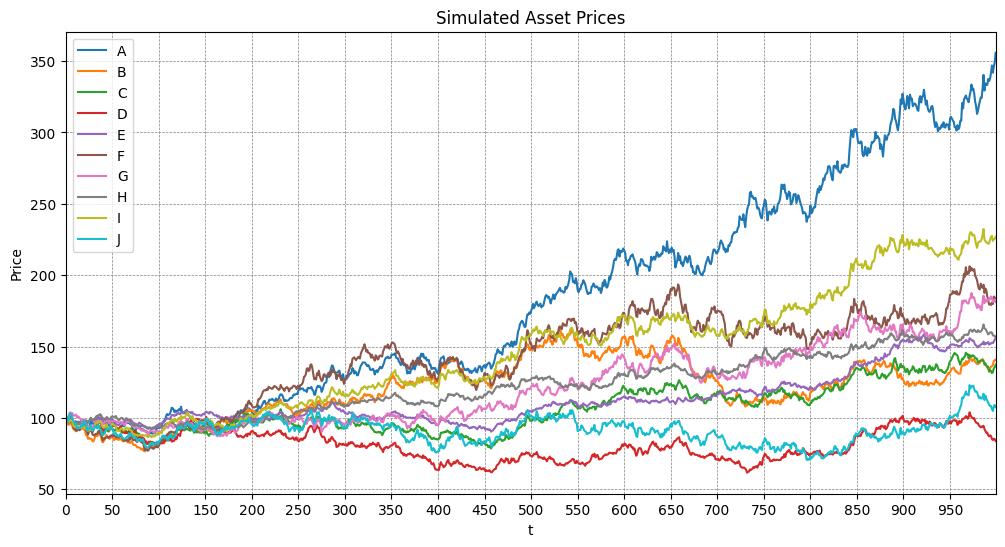

In [13]:
visualizer.plot_asset_prices()

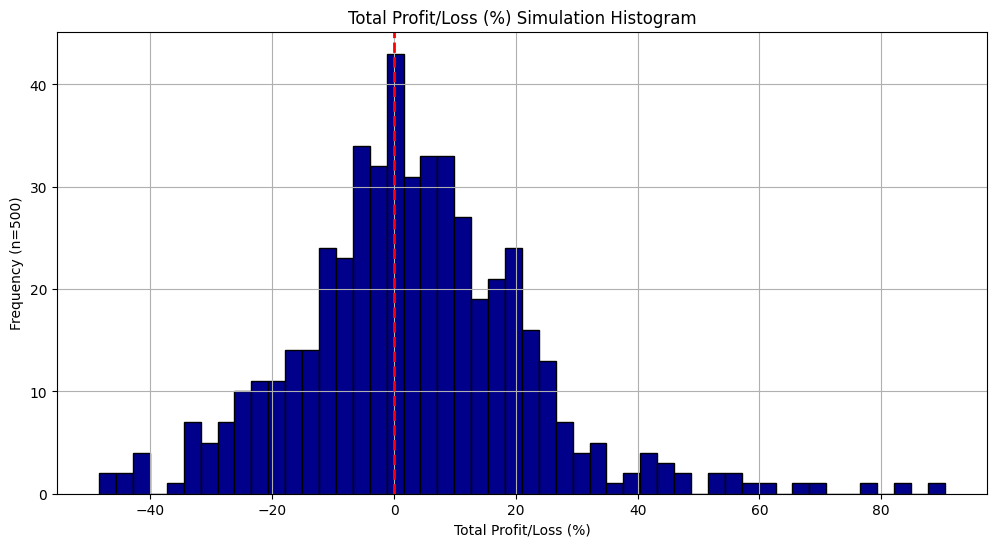

In [14]:
visualizer.plot_histogram()

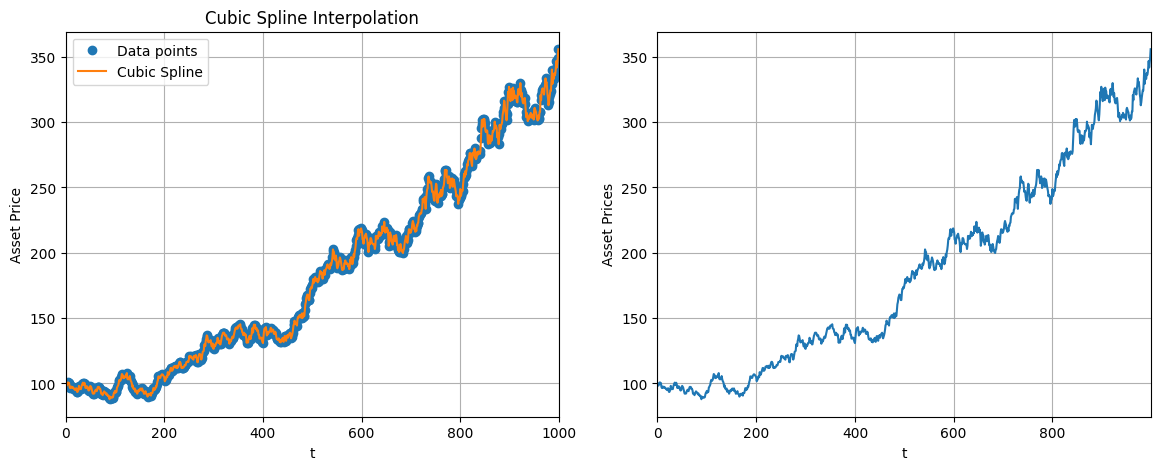

In [15]:
visualizer.plot_interpolation()

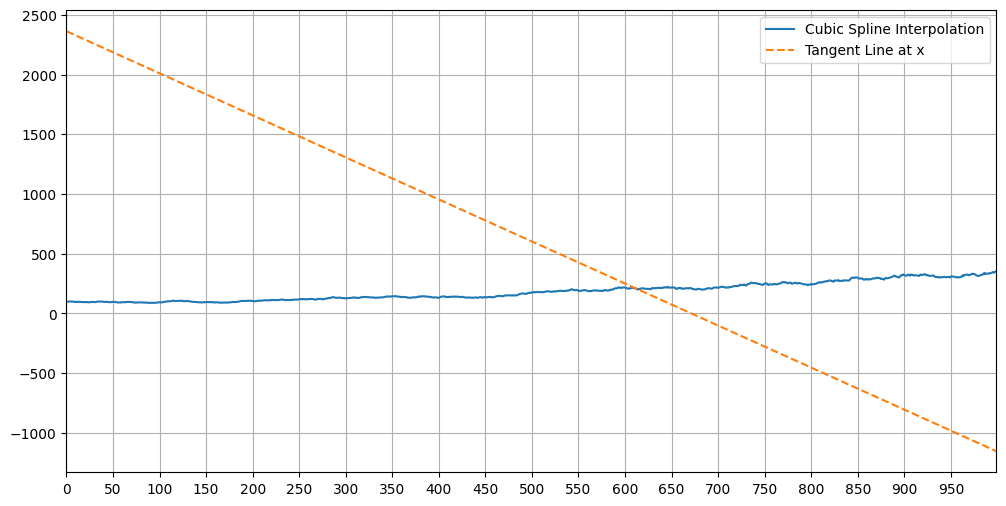

In [16]:
visualizer.plot_tangent_line(x_point, interpolator)

Below is a plot of the optimal signals identified with the first difference.

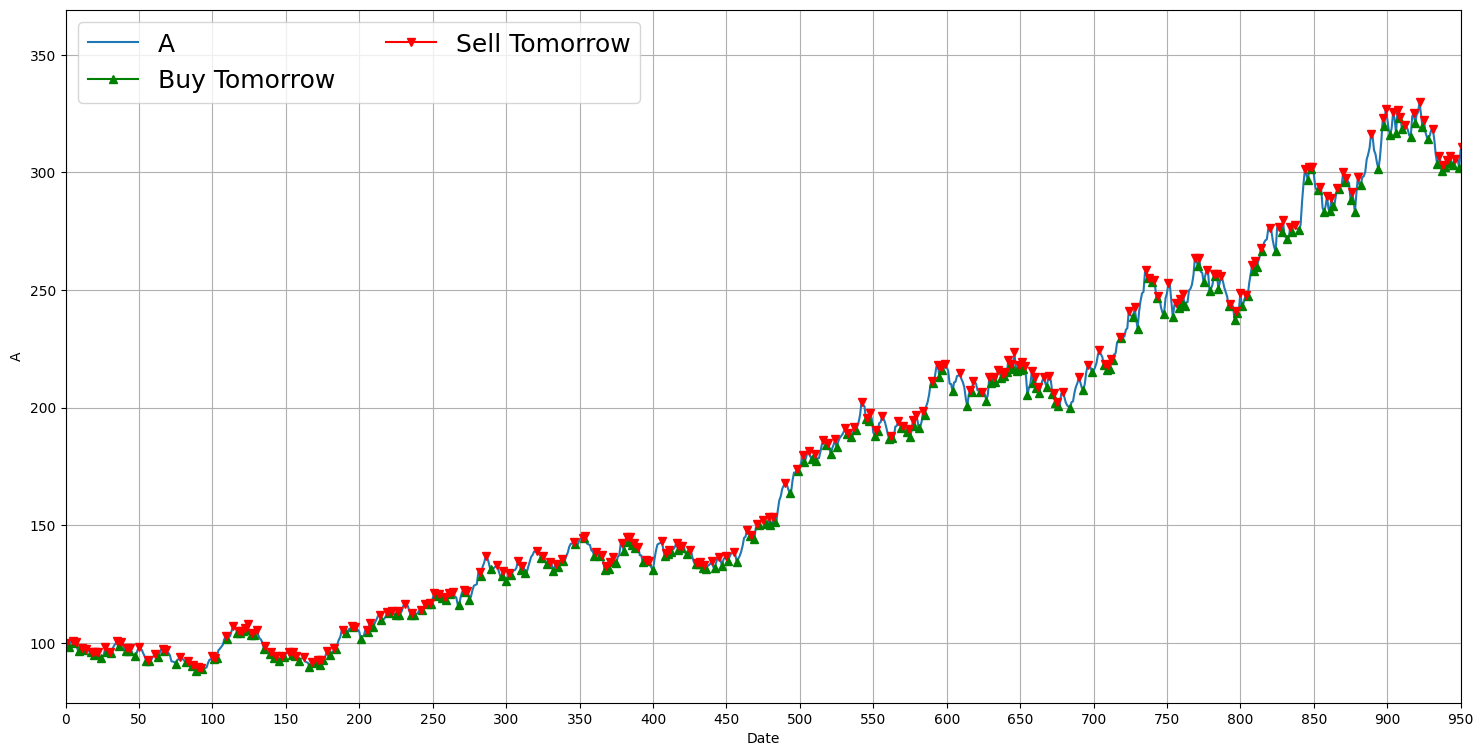

In [17]:
visualizer.plot_FD()

Below is a plot of the optimal signals identified with the derivative of the spline. When comparing the plots it can clearly be seen that the difference between using the first difference and the derivative of the spline through 1000 points to identify the true signals is negligible. We will instead use fewer interpolation points, as discussed in section 3.2.1.

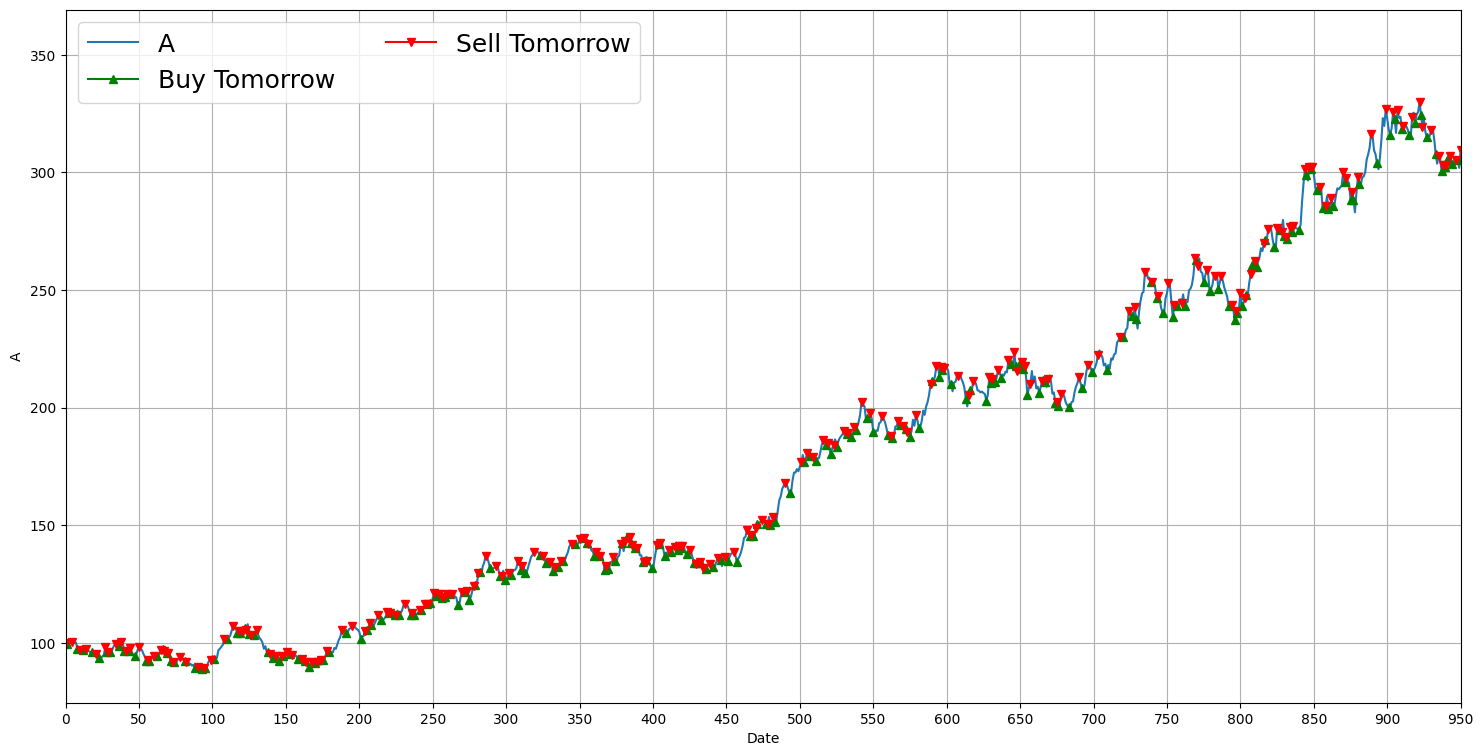

In [18]:
visualizer.plot_interp("A")

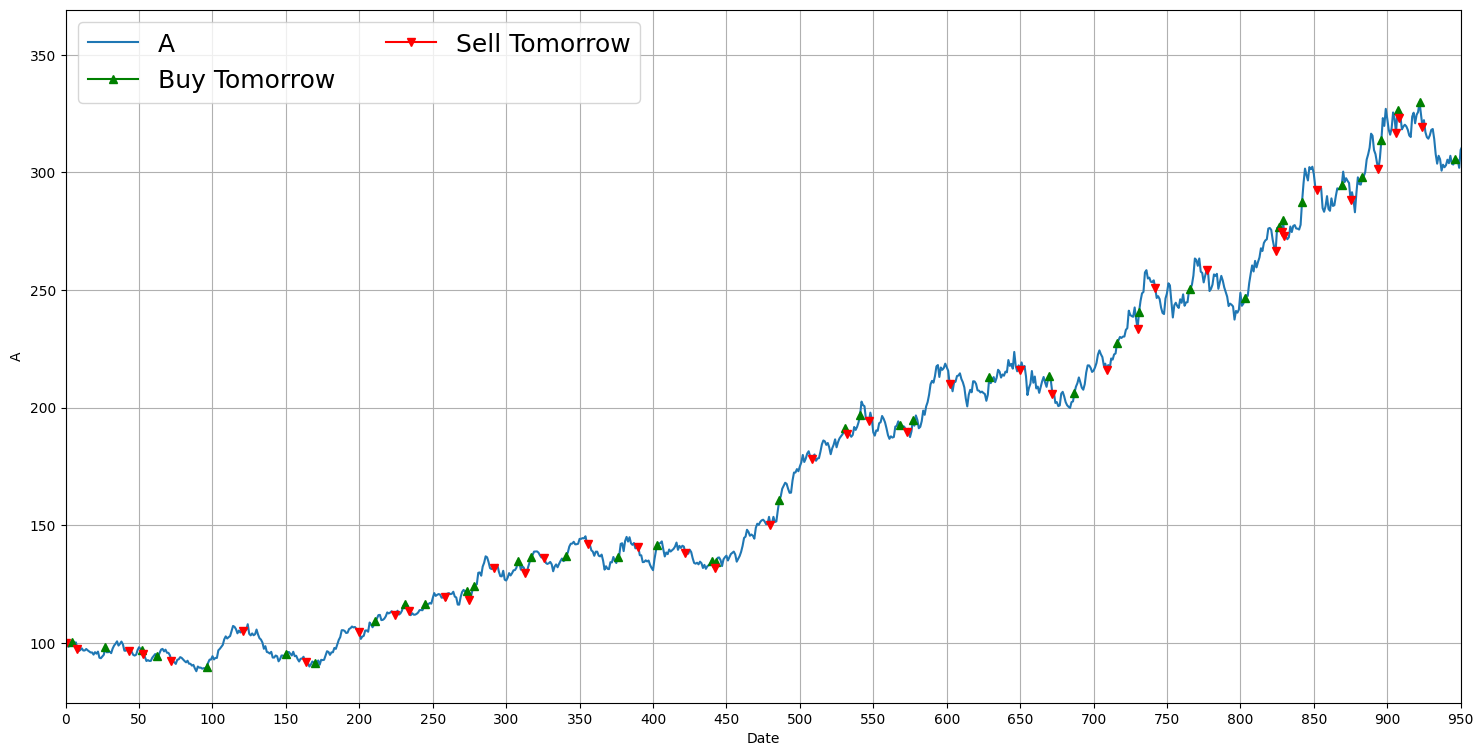

In [19]:
visualizer.plot_pred_signals("A")

From the following result table, we see an expected payoff of 3.1 % for the determined strategy.

In [20]:
results_df

,Win Trades,Loss Trades,Total Profit Loss,Win Loss Ratio
0,23.00,12.00,19.76,0.66
1,10.00,7.00,-2.03,0.59
2,34.00,14.00,78.92,0.71
3,9.00,5.00,3.59,0.64
4,40.00,25.00,70.04,0.62
...,...,...,...,...
496,7.00,2.00,3.61,0.78
497,13.00,9.00,11.80,0.59
498,13.00,6.00,7.59,0.68
499,15.00,4.00,46.90,0.79


# Neural Network Model Approach

In [21]:
%reset -f
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [22]:
class DataPreparation:
    @staticmethod
    def prep_data(stock_prices, split_ratio, prediction_gap):
        total_periods = stock_prices.shape[0]
        split_period = int(total_periods * split_ratio)

        X_train = stock_prices.iloc[:split_period - prediction_gap, :].values
        Y_train = stock_prices.iloc[prediction_gap:split_period, 0].values

        X_test = stock_prices.iloc[split_period:-prediction_gap, :].values
        Y_test = stock_prices.iloc[split_period + prediction_gap:, 0].values

        return X_train, Y_train, X_test, Y_test

In [23]:
class NeuralNetwork:
    @staticmethod
    def swish(x):
        return x / (1 + np.exp(-x))

    @staticmethod
    def swish_derivative(x):
        sigma = 1 / (1 + np.exp(-x))
        return NeuralNetwork.swish(x) + sigma * (1 - NeuralNetwork.swish(x))

    @staticmethod
    def lasso_regularization(weights, lambda_param=0.01):
        return lambda_param * np.sum(np.abs(weights))

    @staticmethod
    def lasso_gradient(weights, lambda_param=0.01):
        return lambda_param * np.sign(weights)

    @staticmethod
    def init_weights(input_size, hidden_sizes, output_size):
        W1 = np.random.randn(input_size, hidden_sizes[0]) * 0.01
        b1 = np.zeros((1, hidden_sizes[0]))

        W2 = np.random.randn(hidden_sizes[0], hidden_sizes[1]) * 0.01
        b2 = np.zeros((1, hidden_sizes[1]))

        W3 = np.random.randn(hidden_sizes[1], output_size) * 0.01
        b3 = np.zeros((1, output_size))

        return W1, b1, W2, b2, W3, b3

    @staticmethod
    def forward_pass(X, W1, b1, W2, b2, W3, b3):
        Z1 = np.dot(X, W1) + b1
        A1 = NeuralNetwork.swish(Z1)
        Z2 = np.dot(A1, W2) + b2
        A2 = NeuralNetwork.swish(Z2)
        Z3 = np.dot(A2, W3) + b3
        output = Z3

        return Z1, A1, Z2, A2, Z3, output

    @staticmethod
    def backward_pass(X, Y, Z1, A1, Z2, A2, Z3, output, W1, b1, W2, b2, W3, b3, learning_rate, lambda_param):
        output_error = output - Y
        output_delta = output_error

        A2_error = np.dot(output_delta, W3.T)
        A2_delta = A2_error * NeuralNetwork.swish_derivative(Z2)

        A1_error = np.dot(A2_delta, W2.T)
        A1_delta = A1_error * NeuralNetwork.swish_derivative(Z1)

        W3 -= learning_rate * (np.dot(A2.T, output_delta) + NeuralNetwork.lasso_gradient(W3, lambda_param))
        b3 -= learning_rate * np.mean(output_delta, axis=0)

        W2 -= learning_rate * (np.dot(A1.T, A2_delta) + NeuralNetwork.lasso_gradient(W2, lambda_param))
        b2 -= learning_rate * np.mean(A2_delta, axis=0)

        W1 -= learning_rate * (np.dot(X.T, A1_delta) + NeuralNetwork.lasso_gradient(W1, lambda_param))
        b1 -= learning_rate * np.mean(A1_delta, axis=0)

        return W1, b1, W2, b2, W3, b3

    @staticmethod
    def train(X, Y, hidden_sizes, epochs, learning_rate, lambda_param):
        input_size = X.shape[1]
        output_size = Y.shape[1]

        W1, b1, W2, b2, W3, b3 = NeuralNetwork.init_weights(input_size, hidden_sizes, output_size)

        for epoch in range(epochs):
            Z1, A1, Z2, A2, Z3, output = NeuralNetwork.forward_pass(X, W1, b1, W2, b2, W3, b3)

            W1, b1, W2, b2, W3, b3 = NeuralNetwork.backward_pass(X, Y, Z1, A1, Z2, A2, Z3, output, W1, b1, W2, b2, W3, b3, learning_rate, lambda_param)

        return W1, b1, W2, b2, W3, b3

In [24]:
class TradeSimulation:
    @staticmethod
    def simulate_trades(output_df, x):
        trades_df = pd.DataFrame(columns=["Buying Period", "Buying Price", "Selling Period", "Selling Price", "Trade Profit/Loss", "Total Profit/Loss"])

        buy_period = buy_price = None
        total_amount = 100

        for period, row in output_df.iterrows():
            if row['Signal'] == 1 and buy_period is None:
                buy_period, buy_price = period, row['Real Prices']
            elif row['Signal'] == -1 and buy_period is not None:
                sell_period, sell_price = period, row['Real Prices']
                trade_profit_loss = (sell_price - buy_price) / buy_price * 100

                total_amount *= (1 + trade_profit_loss / 100)
                total_profit_loss = (total_amount - 100)

                new_trade = pd.DataFrame({
                    "Buying Period": [int(buy_period)],
                    "Buying Price": [buy_price],
                    "Selling Period": [int(sell_period)],
                    "Selling Price": [sell_price],
                    "Trade Profit/Loss": [f"{round(trade_profit_loss, 2)}"],
                    "Total Profit/Loss": [f"{round(total_profit_loss, 2)}"]
                })

                trades_df = pd.concat([trades_df, new_trade], ignore_index=True)
                buy_period = buy_price = None


        return trades_df

In [25]:
class Simulation:
    def __init__(self, runs):
        self.runs = runs
        self.results_df = pd.DataFrame()
        self.output_dfs = []

    @staticmethod
    def generate_correlation_matrix(m):
        while True:
            corr_matrix = np.random.uniform(low=0.0, high=1.0, size=(m, m))
            corr_matrix = (corr_matrix + corr_matrix.T) / 2
            np.fill_diagonal(corr_matrix, 1.0)
            try:
                np.linalg.cholesky(corr_matrix)
                break
            except:
                corr_matrix = np.full((m, m), 0.0)
        return corr_matrix

    def monte_carlo(self, run):
        mu = 0.1
        T = 2000
        delta_t = 1/T

        m = 10
        vols_data = np.random.uniform(low=0.2, high=0.8, size=m)
        S = np.full((m, T), 100.0)
        corr_matrix = self.generate_correlation_matrix(m)
        Q = np.linalg.cholesky(corr_matrix)

        for t in range(1, T):
            random_array = np.random.normal(size=m)
            epsilon_array = np.inner(random_array, Q)

            for n in range(m):
                sigma = vols_data[n]
                epsilon = epsilon_array[n]
                S[n, t] = S[n, t-1] * np.exp((mu - sigma ** 2 / 2) * delta_t + sigma * np.sqrt(delta_t) * epsilon)

        stock_prices = pd.DataFrame(S.T, columns=[f'Asset {i}' for i in range(1, m+1)])
        x = 10
        X_train, Y_train, X_test, Y_test = DataPreparation.prep_data(stock_prices, 0.5, x)

        X_train_standardized = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
        Y_train_standardized = (Y_train - np.mean(Y_train)) / np.std(Y_train)

        hidden_sizes = [5, 3]
        epochs = 1000
        learning_rate = 0.0005
        lambda_param = 0.01
        W1, b1, W2, b2, W3, b3 = NeuralNetwork.train(X_train_standardized, Y_train_standardized.reshape(-1, 1), hidden_sizes, epochs, learning_rate, lambda_param)

        X_test_standardized = (X_test - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
        Y_test_standardized = (Y_test - np.mean(Y_train)) / np.std(Y_train)

        _, _, _, _, _, predicted_standardized = NeuralNetwork.forward_pass(X_test_standardized, W1, b1, W2, b2, W3, b3)
        predicted_prices = predicted_standardized * np.std(Y_train) + np.mean(Y_train)

        output_df = pd.DataFrame({'Predicted Prices': predicted_prices.flatten(), 'Real Prices': stock_prices['Asset 1'].iloc[int(T/2) + x:].values})
        output_df['Absolute Prediction Change'] = output_df['Predicted Prices'].diff()
        output_df['Relative Prediction Change %'] = (output_df['Absolute Prediction Change'] / output_df['Predicted Prices'].shift(1)) * 100

        # Threshold for Signals
        sd_pred = output_df['Absolute Prediction Change'].std()
        threshold = 0.6 + ((2.5 - 0.6) / (1.266 - 0.366)) * (sd_pred - 0.366)  # Linear Interpolation

        # Generating Signals
        output_df['pot. Signal'] = 0
        output_df.loc[output_df['Relative Prediction Change %'] < -(threshold), 'pot. Signal'] = -1
        output_df.loc[output_df['Relative Prediction Change %'] > (threshold), 'pot. Signal'] = 1

        output_df['Signal'] = 0
        current_signal = 1
        last_signal_position = -1

        for index, row in output_df.iterrows():
            if row['pot. Signal'] == current_signal and index > last_signal_position:
                output_df.at[index, 'Signal'] = current_signal
                last_signal_position = index
                current_signal *= -1
        output_df['Signal'] = output_df['Signal'].shift(-x)
        output_df.loc[output_df.index[-x:], 'Signal'] = 0
        output_df.drop('pot. Signal', axis=1, inplace=True)

        trades_df = TradeSimulation.simulate_trades(output_df, x)

        trades_df['Trade Profit/Loss'] = trades_df['Trade Profit/Loss'].astype(float)
        win_trades = len(trades_df[trades_df['Trade Profit/Loss'] > 0])
        loss_trades = len(trades_df[trades_df['Trade Profit/Loss'] < 0])
        total_profit_loss = trades_df['Total Profit/Loss'].iloc[-1] if not trades_df.empty else 0

        if win_trades + loss_trades > 0:
            win_loss_ratio = round(win_trades / (win_trades + loss_trades), 2)
        else:
            win_loss_ratio = 0

        self.output_dfs.append(output_df)

        mse = DataVisualization.calculate_mse(output_df['Real Prices'].values, output_df['Predicted Prices'].values)

        return {
            "MSE": round(mse,2),
            "Win Trades": win_trades,
            "Loss Trades": loss_trades,
            "Win/Loss Trades Ratio": win_loss_ratio,
            "Total Profit/Loss (%)": total_profit_loss
        }

    def run_simulation(self):
        for run in range(self.runs):
            result = self.monte_carlo(run)
            self.results_df = pd.concat([self.results_df, pd.DataFrame([result])], ignore_index=True)
        return self.results_df

In [26]:
class DataVisualization:
    @staticmethod
    def calculate_mse(y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)

    @staticmethod
    def plot_prices(real_prices, predicted_prices):
        plt.figure(figsize=(12, 6))
        plt.plot(real_prices, label='Real Prices', color='black', linewidth=0.4)
        plt.plot(predicted_prices, label='Predicted Prices', color='red', linewidth=0.4)
        plt.title('Real vs Predicted Stock Prices')
        plt.grid(True)
        plt.xlabel('Time Steps')
        plt.xticks(np.arange(0, len(real_prices), step=50))
        plt.xlim(left=0, right=len(real_prices))
        plt.ylabel('Price')
        plt.legend()
        plt.show()

    @staticmethod
    def plot_signals(real_prices, signals):
        plt.figure(figsize=(12, 6))
        plt.plot(real_prices, label='Real Prices', color='black', linewidth=0.2)
        plt.scatter(signals.index[signals == 1], real_prices[signals == 1], marker='^', color='green', label='Buy Signal')
        plt.scatter(signals.index[signals == -1], real_prices[signals == -1], marker='v', color='red', label='Sell Signal')
        plt.title('Signals on Real Price Curve')
        plt.xlabel('Time Steps')
        plt.ylabel('Price')
        plt.grid(True)
        plt.xticks(np.arange(0, len(real_prices), step=50))
        plt.xlim(left=0, right=len(real_prices))
        plt.legend()
        plt.show()

    @staticmethod
    def plot_profit_loss_histogram(results_df):
        plt.figure(figsize=(12, 6))
        plt.hist(results_df['Total Profit/Loss (%)'][:-1], bins=50, color='darkblue', edgecolor='black')
        plt.title('Total Profit/Loss (%) Simulation Histogram')
        plt.xlabel('Total Profit/Loss (%)')
        plt.ylabel('Frequency (n={})'.format(len(results_df)-1))
        plt.grid(True)
        plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
        plt.show()

    @staticmethod
    def plot_mse(results_df):
        plt.figure(figsize=(12, 6))
        plt.hist(results_df['MSE'][:-1], bins=100, color='darkblue', edgecolor='black')
        plt.title('Mean Squared Error (MSE) Simulation Histogram')
        plt.xlabel('MSE')
        plt.ylabel(f'Frequency (n={len(results_df)-1})')
        plt.grid(True)
        plt.show()

    @staticmethod
    def plot_sim(simulation, run_indices=None):
        if run_indices is None:
            run_indices = range(len(simulation.output_dfs))
        elif not run_indices:
            pass
        else:
            for i in run_indices:
                print(f"--- Run {i} ---")
                mse = DataVisualization.calculate_mse(simulation.output_dfs[i]["Real Prices"], simulation.output_dfs[i]["Predicted Prices"])
                print(f"Mean Squared Error: {mse}")
                DataVisualization.plot_prices(simulation.output_dfs[i]['Real Prices'], simulation.output_dfs[i]['Predicted Prices'])
                DataVisualization.plot_signals(simulation.output_dfs[i]['Real Prices'], simulation.output_dfs[i]['Signal'])

        print(f"--- MSE Histogram ---")
        DataVisualization.plot_mse(results_df)
        print(f"--- Profit/Loss Histogram ---")
        DataVisualization.plot_profit_loss_histogram(results_df)


--- Run 499 ---
Mean Squared Error: 13.76577875408941


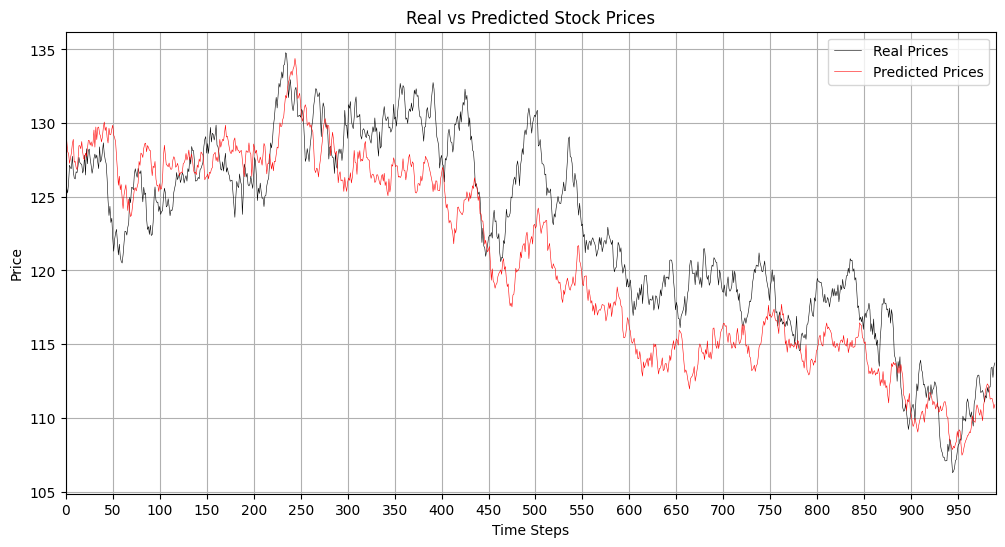

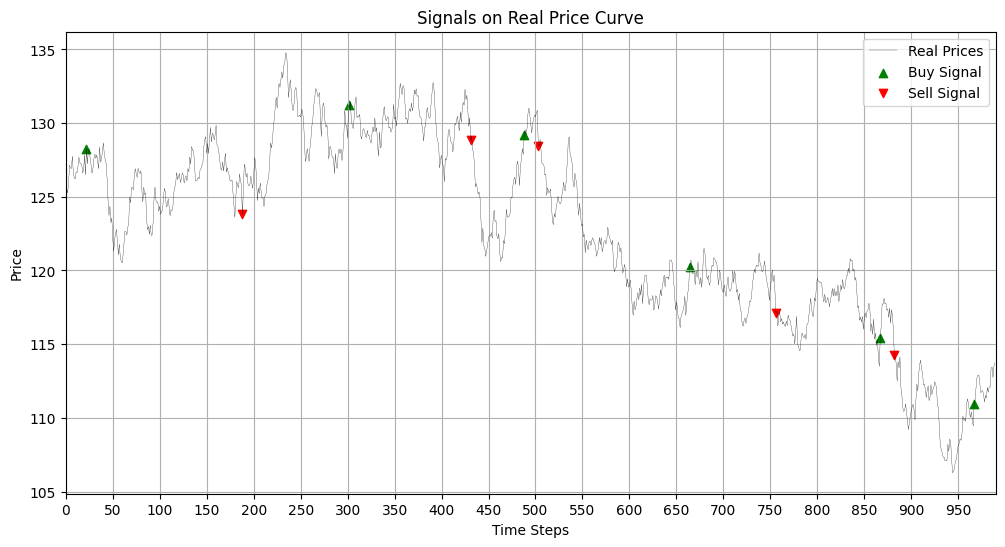

--- MSE Histogram ---


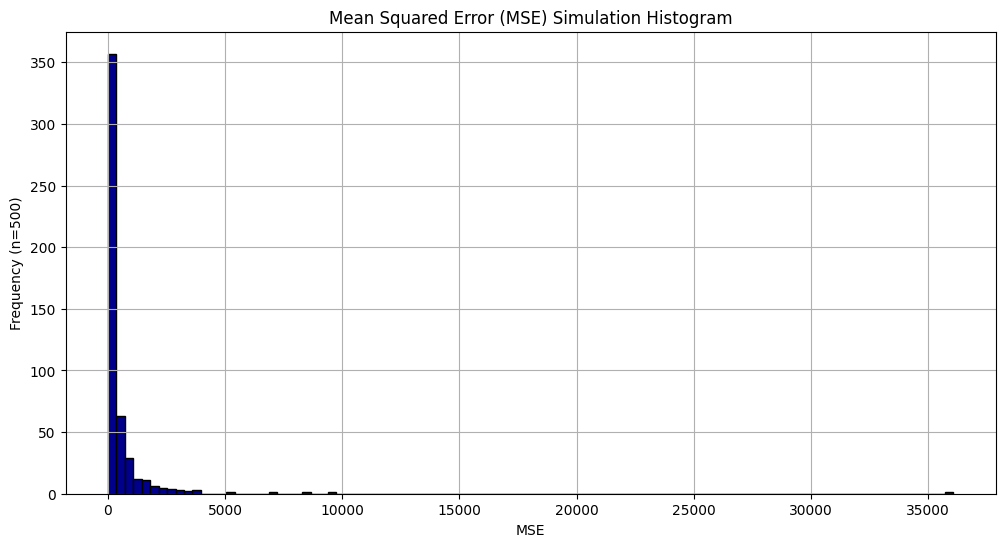

--- Profit/Loss Histogram ---


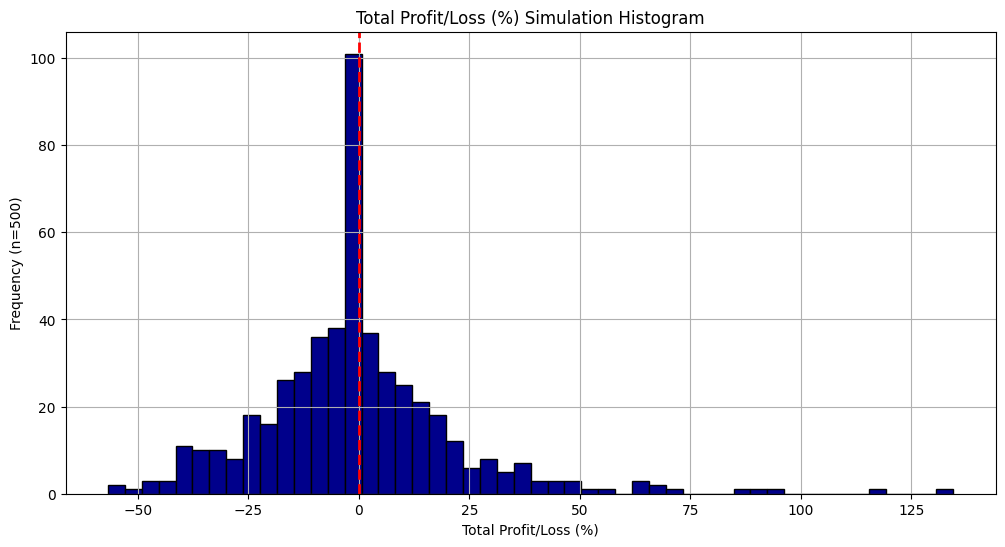

In [28]:
# Main program
n = 500
np.random.seed(1)
simulation = Simulation(n)
results_df = simulation.run_simulation().astype(float)
results_df.loc['Average'] = round(results_df.mean(numeric_only=False), 2)

# Set indices of simulations to plot: run_indices=None to plot all, [] to plot no and [x,y] to plot specific simulations
DataVisualization.plot_sim(simulation, run_indices=[random.randint(0, n)])
results_df

# Conclusion: 
We have been able to prove that both models are suitable for generating a trading strategy. Precise refinements can be created on this basis.
